Task 1

Number of nodes: 1574
Number of edges: 17215
Adjacency matrix shape: (1574, 1574)
Top-left 10x10 block of the adjacency matrix:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


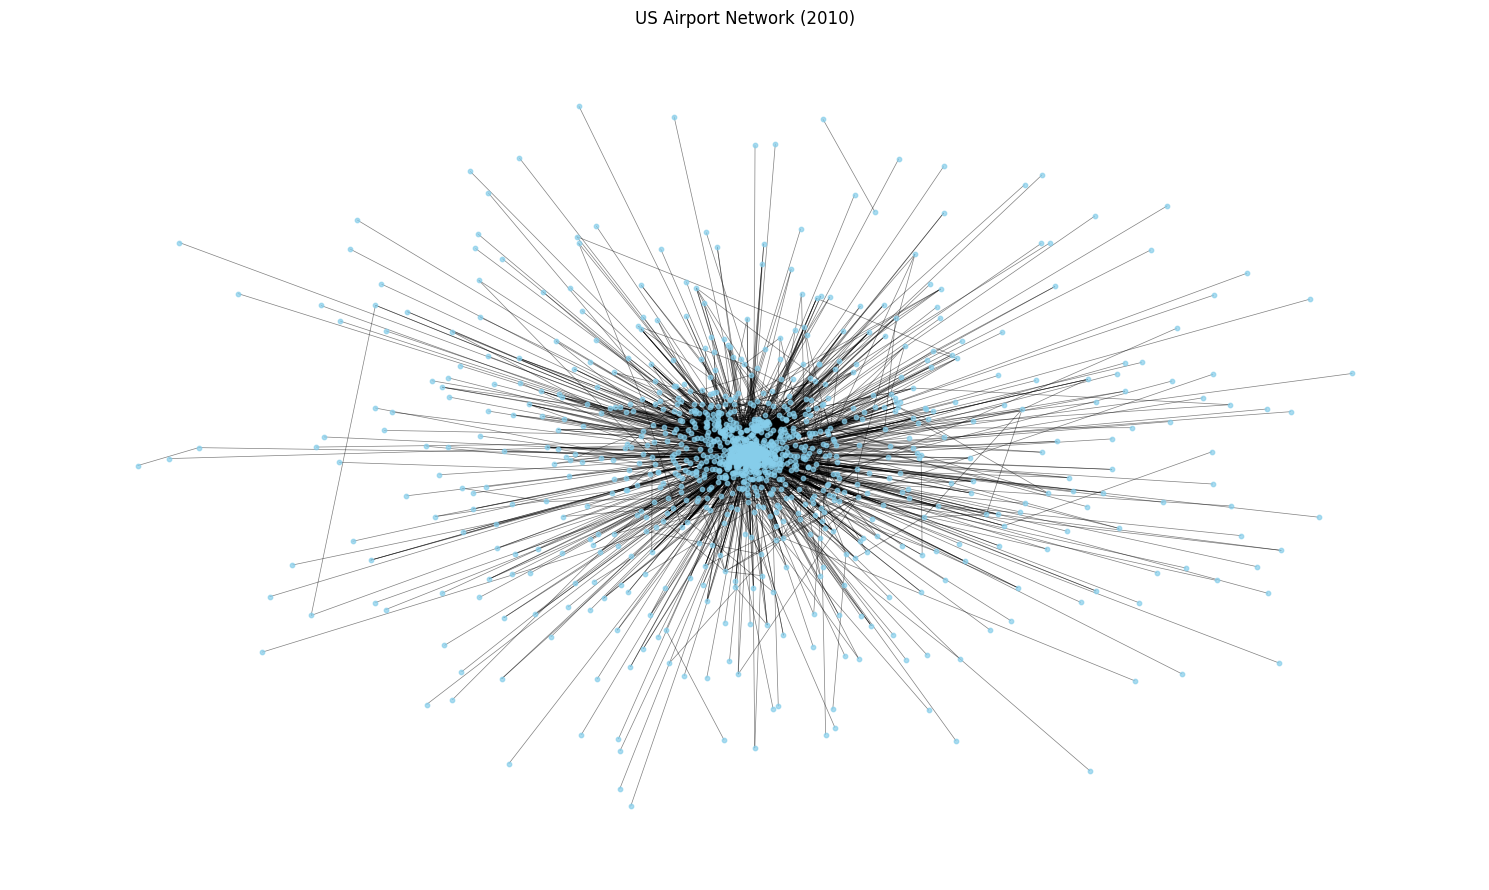

In [1]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# ===== Step 1: Import Data =====
# Define file paths (ensure these files are in your working directory)
edges_file = "USairport_2010.txt"
codes_file = "USairport_2010_codes.txt"

# Load the edges list using a MultiGraph (this allows duplicate edges).
# Each line in the file contains: source target weight.
graphtype = nx.MultiGraph()
Gm = nx.read_weighted_edgelist(edges_file, create_using=graphtype, nodetype=int)

# ===== Step 2: Create a Simple Graph with Summed Edge Weights =====
# We want to remove duplicate edges by summing their weights.
G = nx.Graph()
for u, v, data in Gm.edges(data=True):
    w = data.get('weight', 1.0)
    # If an edge already exists, update (sum) its weight; otherwise add the edge.
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
    elif w != 0:  # ignore edges with zero weight (e.g., cargo-only)
        G.add_edge(u, v, weight=w)

# ===== Step 3: Add Node Labels from the Codes File =====
# The codes file contains the mapping: node_id and airport code.
nodes_df = pd.read_csv(codes_file, header=None, delimiter=' ', engine='python')
# Assume the first column is the node id and the second column is the airport code.
for _, row in nodes_df.iterrows():
    node_id = int(row[0])
    code = row[1]
    # Add a node attribute only if the node is in the graph; extra nodes from the codes file are not added.
    if node_id in G.nodes:
        G.nodes[node_id]['code'] = code

# ===== Step 4: Clean the Graph =====
# Remove nodes with no connections (isolated nodes).
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

# Retrieve airport codes to be used later in prints and analysis.
codes = nx.get_node_attributes(G, 'code')

# ===== Step 5: Basic Network Statistics =====
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print('Number of nodes:', num_nodes)
print('Number of edges:', num_edges)

# ===== Step 6: Create the Adjacency Matrix =====
# There are two main ways:
#   - as a SciPy sparse matrix (using nx.adjacency_matrix)
#   - as a dense numpy array (using nx.to_numpy_array)
adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Adjacency matrix shape:", adj_matrix.shape)
# Display a small portion (e.g., top-left 10x10 block) for inspection.
print("Top-left 10x10 block of the adjacency matrix:\n", adj_matrix[:10, :10])

# ===== Step 7: Optional Visualization =====
# Compute positions for nodes using a spring layout.
pos = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(figsize=(15, 9))
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=10, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
plt.title("US Airport Network (2010)")
plt.axis('off')
plt.tight_layout()
plt.savefig('network.png', dpi=100)
plt.show()


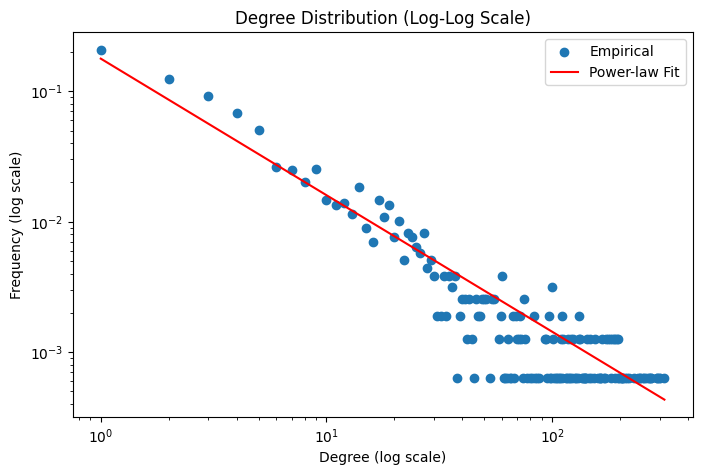

In [2]:
# Degree distribution (log-log)
deg_hist = np.array(nx.degree_histogram(G))
deg = np.arange(len(deg_hist))
nonzero = deg_hist > 0
norm_freq = deg_hist[nonzero] / deg_hist.sum()
log_deg = np.log(deg[nonzero])
log_freq = np.log(norm_freq)
coef = np.polyfit(log_deg, log_freq, 1)
xx = np.arange(1, len(deg_hist))
yy = np.exp(coef[1]) * xx**coef[0]

plt.figure(figsize=(8, 5))
plt.scatter(deg[nonzero], norm_freq, label='Empirical')
plt.plot(xx, yy / np.sum(yy), color='red', label='Power-law Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution (Log-Log Scale)')
plt.legend()
plt.savefig('degree_distribution.png', dpi=300)
plt.show()

In [3]:
import networkx as nx
import pandas as pd

# Define file paths (ensure these files are in your working directory)
edges_file = "USairport_2010.txt"
codes_file = "USairport_2010_codes.txt"

# --- Create a MultiGraph from the edges file ---
Gm = nx.read_weighted_edgelist(edges_file, create_using=nx.MultiGraph(), nodetype=int)

# --- Build a Simple Graph by Summing Duplicate Edges ---
G = nx.Graph()
for u, v, data in Gm.edges(data=True):
    w = data.get('weight', 1.0)
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
    elif w != 0:  # ignore zero-weight edges
        G.add_edge(u, v, weight=w)

# --- Add Node Attributes (airport codes) ---
nodes_df = pd.read_csv(codes_file, header=None, delimiter=' ', engine='python')
for _, row in nodes_df.iterrows():
    node_id, code = int(row[0]), row[1]
    if node_id in G.nodes:
        G.nodes[node_id]['code'] = code

# --- Remove isolated nodes (nodes with no connections) ---
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

# --- Create the 'codes' dictionary for later lookup ---
codes = nx.get_node_attributes(G, 'code')

# Optional: Print basic statistics to verify network construction
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 1574
Number of edges: 17215


Task 2

In [4]:
import networkx as nx

# 1. Eigenvector Centrality
# Compute the eigenvector centrality (using the power-iteration method) on the largest connected component.
eigen = nx.eigenvector_centrality(
    G,
    weight="weight",
    max_iter=1000,
    tol=1e-06
)

# Extract largest connected component and recompute using a more robust numpy-based method.
largest_cc = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_cc)
eigen_sub = nx.eigenvector_centrality_numpy(G0, weight="weight")
# For nodes not in the largest connected component, assign a score of zero.
eigen = {n: eigen_sub.get(n, 0.0) for n in G}

# 2. Katz Centrality
# Using the numpy-based method which is often more robust.
katz = nx.katz_centrality_numpy(G, alpha=0.005, beta=1.0, weight="weight")

# 3. Betweenness Centrality (weighted, normalized)
betw = nx.betweenness_centrality(G, weight="weight", normalized=True)

# 4. Closeness Centrality
# Here we treat the weight as distance (i.e., distance = 1/weight).
close = nx.closeness_centrality(
    G,
    distance=lambda u, v, d: 1.0 / d["weight"]
)

# 5. HITS (hub and authority scores)
hits_hub, hits_auth = nx.hits(G, max_iter=100, normalized=True)

# --- Helper Function to Print Top N Nodes per Metric ---
def print_top(metric, name, n=10):
    ranked = sorted(metric.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop {n} by {name}:")
    for node, score in ranked[:n]:
        print(f"  {codes[node]:<4}  {score:.4f}")

# --- Print Results ---
print_top(eigen,    "Eigenvector Centrality")
print_top(katz,     "Katz Centrality")
print_top(betw,     "Betweenness Centrality")
print_top(close,    "Closeness Centrality")
print_top(hits_hub, "HITS (Hub Scores)")
print_top(hits_auth,"HITS (Authority Scores)")




Top 10 by Eigenvector Centrality:
  ATL   0.3188
  ORD   0.2769
  LAX   0.2732
  DEN   0.2405
  DFW   0.2390
  SFO   0.2150
  LAS   0.1998
  PHX   0.1908
  MCO   0.1730
  IAH   0.1612

Top 10 by Katz Centrality:
  JHW   0.4807
  BFD   0.4720
  EVV   0.1404
  DLH   0.1213
  ATW   0.1193
  MGM   0.1168
  ILG   0.1086
  MSL   0.1061
  SWF   0.1014
  MOB   0.0993

Top 10 by Betweenness Centrality:
  ANC   0.2467
  TEB   0.1611
  FAR   0.1371
  BUR   0.1301
  HPN   0.1177
  DLH   0.0903
  FBK   0.0832
  IAD   0.0788
  FAI   0.0780
  NUL   0.0707

Top 10 by Closeness Centrality:
  LAX   18.0365
  ATL   18.0365
  ORD   18.0365
  DEN   18.0365
  SEA   18.0364
  SFO   18.0364
  DFW   18.0364
  LAS   18.0364
  JFK   18.0364
  PHX   18.0364

Top 10 by HITS (Hub Scores):
  ATL   0.0367
  ORD   0.0318
  LAX   0.0314
  DEN   0.0277
  DFW   0.0275
  SFO   0.0247
  LAS   0.0230
  PHX   0.0219
  MCO   0.0199
  IAH   0.0185

Top 10 by HITS (Authority Scores):
  ATL   0.0367
  ORD   0.0318
  LAX   0.031

Task 3

Number of communities detected: 20
Modularity score of the partition: 0.2541


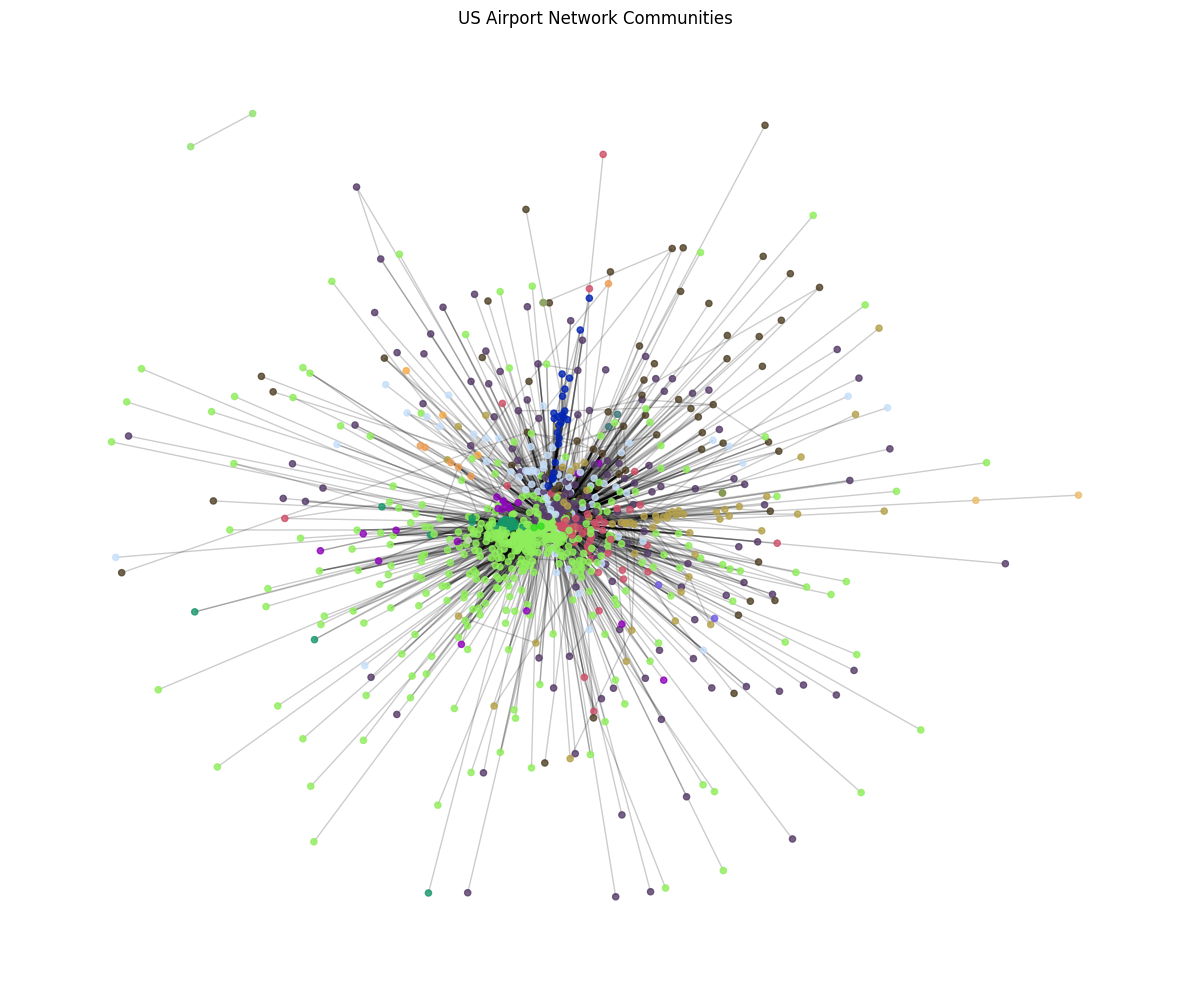

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from networkx.algorithms.community import greedy_modularity_communities, modularity

# --------- Community Detection using Greedy Modularity ---------------
# Find communities (each community is a set of nodes)
communities = list(greedy_modularity_communities(G, weight='weight'))

# Count the number of communities
num_communities = len(communities)
print("Number of communities detected:", num_communities)

# Compute the modularity score of the partition
mod_score = modularity(G, communities, weight='weight')
print("Modularity score of the partition: {:.4f}".format(mod_score))

# Optional: Create a community assignment dictionary for visualization
# Each node gets a community id (integer)
community_assignment = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_assignment[node] = i

# --------- Visualization of Communities -----------------------------
# Use a spring layout for better visual separation
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)

# Generate random colors for each community.
colors = {}
for i in range(num_communities):
    # Choose a random color in hex format
    colors[i] = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

# Draw nodes: assign color based on community id.
node_colors = [colors[community_assignment[node]] for node in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("US Airport Network Communities")
plt.axis("off")
plt.tight_layout()
plt.savefig("communities.png", dpi=100)
plt.show()


Task 4

Assortativity coefficient: -0.11329543383693774


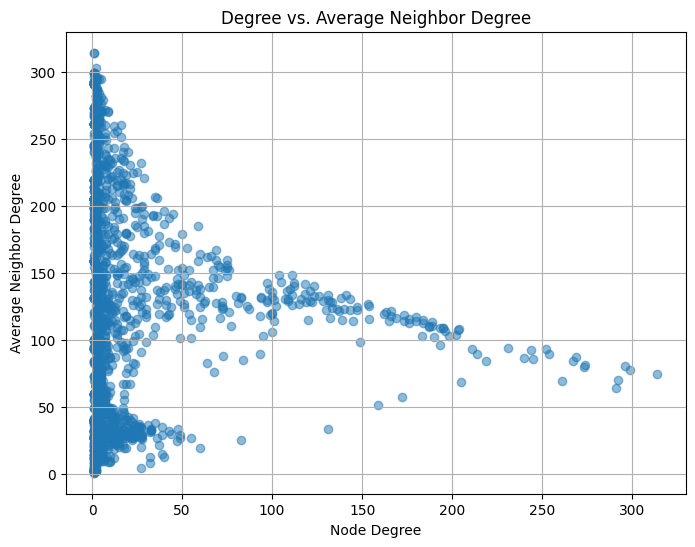

In [6]:
# === Task 4: Assortativity ===
assortativity = nx.degree_assortativity_coefficient(G)
print("Assortativity coefficient:", assortativity)

deg_dict = dict(G.degree())
avg_deg = nx.average_neighbor_degree(G)

x = [deg_dict[n] for n in G]
y = [avg_deg[n] for n in G]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel("Node Degree")
plt.ylabel("Average Neighbor Degree")
plt.title("Degree vs. Average Neighbor Degree")
plt.grid(True)
plt.savefig('degree_assortativity.png', dpi=300)
plt.show()

Task 5

In [7]:
import networkx as nx

# Assuming G is your graph
global_clustering = nx.transitivity(G)
print(f"Global Clustering Coefficient: {global_clustering}")

import networkx as nx

# Number of nodes and edges in the original graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Generate a random graph with similar size and density
random_graph = nx.gnm_random_graph(num_nodes, num_edges)

# Compute the global clustering coefficient for the random graph
random_global_clustering = nx.transitivity(random_graph)
print(f"Random Graph Global Clustering Coefficient: {random_global_clustering}")


Global Clustering Coefficient: 0.38414344664491556
Random Graph Global Clustering Coefficient: 0.013444612487385743


Local Clustering Coefficient of node 1: 1.0


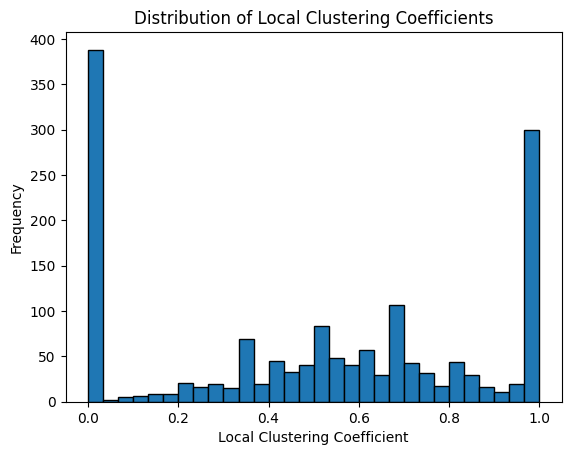

Top 10 nodes by degree and their local clustering coefficients:
Node 114 (Degree: 314) - Clustering: 0.1839
Node 709 (Degree: 299) - Clustering: 0.1965
Node 1200 (Degree: 296) - Clustering: 0.2163
Node 877 (Degree: 292) - Clustering: 0.1636
Node 766 (Degree: 291) - Clustering: 0.1361
Node 389 (Degree: 274) - Clustering: 0.2150
Node 500 (Degree: 273) - Clustering: 0.2129
Node 1068 (Degree: 269) - Clustering: 0.2447
Node 711 (Degree: 267) - Clustering: 0.2351
Node 1016 (Degree: 261) - Clustering: 0.1593


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph
# First, compute the local clustering coefficients
local_clustering = nx.clustering(G)

# Print clustering coefficient of the first node in the graph
first_node = list(local_clustering.keys())[0]
print(f"Local Clustering Coefficient of node {first_node}: {local_clustering[first_node]}")

# Get degree of all nodes
degree_dict = dict(G.degree())

# Values of local clustering coefficients
clustering_values = list(local_clustering.values())

# Plot histogram
plt.hist(clustering_values, bins=30, edgecolor='black')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Local Clustering Coefficients')
plt.show()

# Sort nodes by degree (descending)
top_degree_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Print local clustering coefficient of top-degree nodes
print("Top 10 nodes by degree and their local clustering coefficients:")
for node, degree in top_degree_nodes:
    print(f"Node {node} (Degree: {degree}) - Clustering: {local_clustering[node]:.4f}")
